In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import imagesize
import concurrent.futures
import tensorflow as tf
import os
import time


import torchxrayvision as xrv
import skimage, torch, torchvision
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import torchxrayvision as xrv

from PIL import Image
from pathlib import Path


2024-02-05 20:33:58.429794: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 20:33:58.476951: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setting up DataFrames

In [24]:
test_df = pd.read_csv('test.txt', header=None)
train_df = pd.read_csv('train.txt', header=None)
validation_df = pd.read_csv('val.txt', header=None)

split_function = lambda df: df[0].str.split(' ', expand=True)
rename_function = lambda df: df.rename(columns={0: "test_id", 1: 'filename', 2: 'test_result', 3: 'data_source'}, inplace=False)

test_df = rename_function(split_function(test_df))
train_df = rename_function(split_function(train_df))
validation_df = rename_function(split_function(validation_df))

# all_df = [test_df, train_df, validation_df]

In [25]:
validaton_df.head()

,test_id,filename,test_result,data_source,full_filepath,x_shape,y_shape,x_shape,y_shape
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-003251-46647-0.png,1024,826,1024,826
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-001464-39871-0.png,1024,790,1024,790
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-000918-78965-0.png,1024,851,1024,851
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-003318-64285-0.png,1024,851,1024,851
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-001015-81591-0.png,1024,791,1024,791


In [26]:
create_filepath = lambda df, dir_name: df.assign(full_filepath=df.apply(lambda row: os.path.join(dir_name, row.filename), axis=1))

test_df = create_filepath(test_df, "test")
train_df = create_filepath(train_df, "train")
validation_df = create_filepath(validation_df, "val")

In [27]:
test_df.head()

,test_id,filename,test_result,data_source,full_filepath
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-003251-46647-0.png
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-001464-39871-0.png
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-000918-78965-0.png
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-003318-64285-0.png
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord,test/MIDRC-RICORD-1C-419639-001015-81591-0.png


### Enriching

In [28]:
# THIS TAKES A HOT MINUTE

# Define the function to add dimensions to a single row
def add_image_dimensions(row):
    width, height = imagesize.get(row.full_filepath)
    return pd.Series([width, height], index=['x_shape', 'y_shape'])

# Function to process a single dataframe
def process_dataframe(df):
    dimensions = df.apply(add_image_dimensions, axis=1)
    return pd.concat([df, dimensions], axis=1)

In [29]:
test_df = process_dataframe(test_df)
train_df = process_dataframe(train_df)
validation_df = process_dataframe(validation_df)

In [30]:
validation_df.head()

,test_id,filename,test_result,data_source,full_filepath,x_shape,y_shape
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed,val/CR.1.2.840.113564.1722810170.2020031808292...,1024,808
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed,val/CR.1.2.840.113564.1722810170.2020032001125...,1024,842
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv,val/sub-S03044_ses-E06138_run-1_bp-chest_vp-ap...,1024,842
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv,val/sub-S03044_ses-E07712_run-1_bp-chest_vp-ap...,1024,842
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv,val/sub-S03044_ses-E06790_run-1_bp-chest_vp-pa...,1024,843


In [31]:
def to_shape(a, y_, x_):
    a = tf.squeeze(a)
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant')

# Initialize the model
model = xrv.baseline_models.chestx_det.PSPNet()

# Define the transformation
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(512)])

Setting XRayResizer engine to cv2 could increase performance.


In [45]:
# Define the function to process an individual image
def process_image(img_path, save_folder):
    # Read and process the image
    img = skimage.io.imread(img_path)
    img = xrv.datasets.normalize(img, 255)
    if img.ndim == 2:
        img = img[None, ...]
    elif img.ndim == 3:
        img = img.mean(2)[None, ...]

    img = transform(img)
    img_tensor = torch.from_numpy(img)
    
    # Get the model prediction
    with torch.no_grad():
        pred = model(img_tensor)

    # Process the prediction
    pred = 1 / (1 + np.exp(-pred))
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 1
    
    lung_mask = pred[0, 0]  # Adjust this index based on how your model outputs the prediction

    # Find the indices where lung_mask is 1
    lung_indices = np.where(lung_mask == 1)
    
    right_lung_index = model.targets.index('Right Lung')
    left_lung_index = model.targets.index('Left Lung')
    
    
    # Pull out just the lung pixels that we care about, using a logical or
    segmented_lungs_prediction = np.logical_or(pred[0,left_lung_index], pred[0,right_lung_index])
    
    # Map this back onto the original image
    segmented_lungs = segmented_lungs_prediction*img
        
    padded_segmented_lungs = to_shape(segmented_lungs, max_y, max_x)
    
    im_path, _ = os.path.splitext(img_path)

    file_name = f'{save_folder}/{im_path}'
    np.save(file_name, padded_segmented_lungs)
    
    return None

#     # Calculate the extents
#     top_extent = np.min(lung_indices[0]) if lung_indices[0].size > 0 else None
#     bottom_extent = np.max(lung_indices[0]) if lung_indices[0].size > 0 else None
#     left_extent = np.min(lung_indices[1]) if lung_indices[1].size > 0 else None
#     right_extent = np.max(lung_indices[1]) if lung_indices[1].size > 0 else None
    
#     # Find the center x,y of the lungs
#     center_x = right_extent-left_extent
#     center_y = bottom_extent-top_extent

#     return left_extent, right_extent, top_extent, bottom_extent

# Define the function to process a single dataframe
def process_dataframe(df, save_folder):
    # Apply the image processing to each row
    df['full_filepath'].apply(lambda x: process_image(x, save_folder))



In [46]:
max_x = max(test_df['x_shape'].max(), train_df['x_shape'].max(), validation_df['x_shape'].max())
max_y = max(test_df['y_shape'].max(), train_df['y_shape'].max(), validation_df['y_shape'].max())

In [52]:

# TODO: Check to make sure this works
# Process each dataframe
start = time.time()
# all_df_processed = [process_dataframe(df) for df in all_df]
process_dataframe(validation_df.head(10), 'etl_output')
print(time.time() - start)

12.644643306732178


In [ ]:
#print(df.describe())

In [53]:
data = np.load('etl_output/val/sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-corrected.npy')

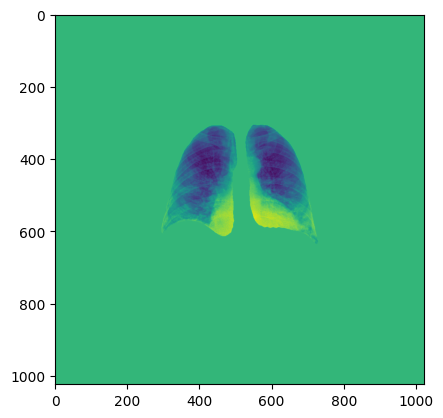

In [54]:
plt.imshow(data)